### GTSRB Traffic Sign Recognition - Part III

### CODE ONLY, For a detailed report, please refer to the GTSRB Final Report Part III

#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing necessary modules
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import GTSRB_sungil           # preprocessing

Using TensorFlow backend.


### Preprocessing

In [3]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = GTSRB_sungil.load_data(num_classes)
gray_GTSRB = GTSRB_sungil.gray_convrt(data_GTSRB)

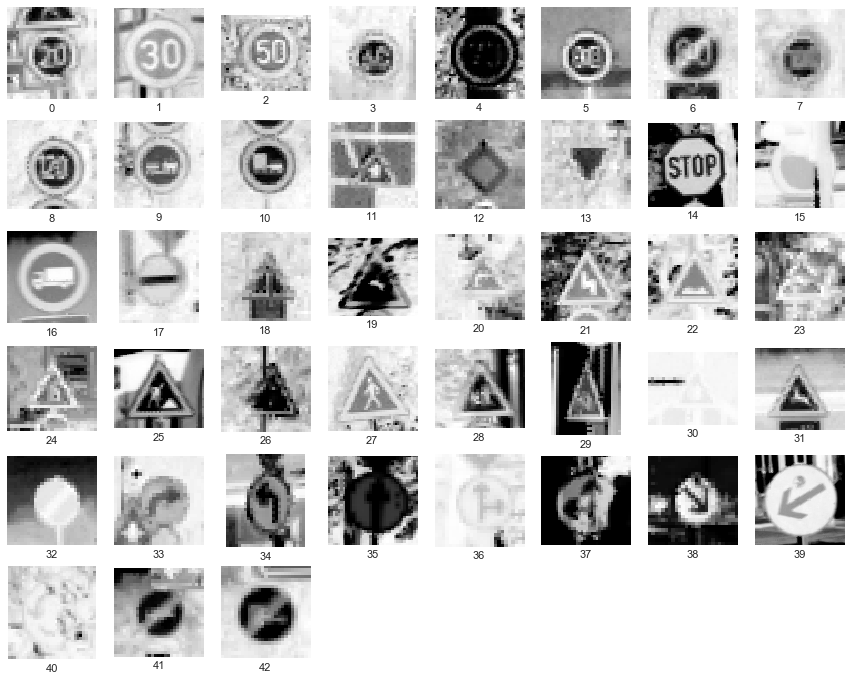

In [4]:
# one image example from each class, pre grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gray_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

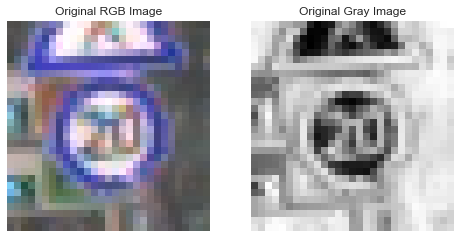

In [5]:
# original and post grayscale comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.show()

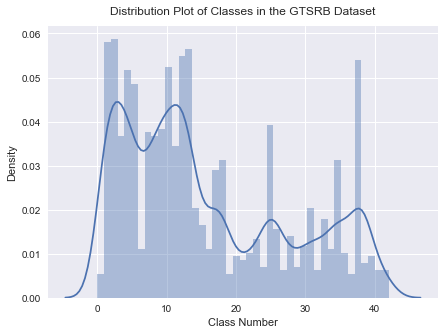

Total 39209 images in the GTSRB dataset
Total 39209 classes in the GTSRB class


In [6]:
# original class distribution
fig = plt.figure(figsize = (7, 5))
sns.distplot(data_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the GTSRB Dataset', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

# length of the data
print('Total %i images in the GTSRB dataset' % len(data_GTSRB))
print('Total %i classes in the GTSRB class' % len(data_class))

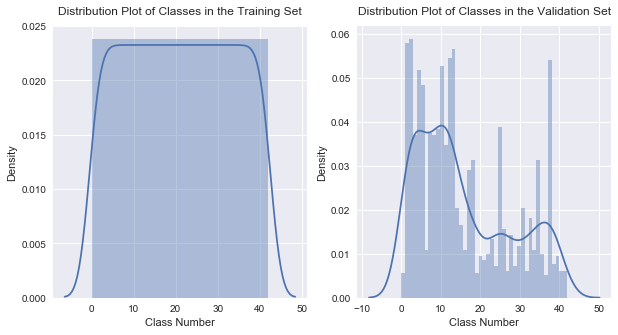

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [7]:
# resizing
resize_data = GTSRB_sungil.resize_all(gray_GTSRB, size = (28, 28))

# normalizing data, RGB/grayscale images are out of 255
norm_resized = resize_data / 255.0

# reshaping to be suitable for keras and tensorflow
nn_reshaped = GTSRB_sungil.nn_reshape(norm_resized)

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
x_train, x_val, y_class, y_val = train_test_split(nn_reshaped, data_class,\
                                                  stratify = data_class, test_size = 0.055)

# random under-sampling
und_train, und_class = GTSRB_sungil.under_sample(x_train, y_class)

# converting a class vector to binary class matrix
y_class_bin = keras.utils.to_categorical(und_class, num_classes)
y_val_bin = keras.utils.to_categorical(y_val, num_classes)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_train) + len(x_val)
print('Total of %i images in the training data' % len(und_train))
print('Total of %i images in the validation data' % len(x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_train)/tot_len*100, len(x_val)/tot_len*100))

### Exploring with ConvNet Architectures

#### Small (Conv-Pool-Dropout)

In [8]:
model1 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history1 = model1.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 55s 6ms/step - loss: 2.8236 - acc: 0.2795 - val_loss: 1.6585 - val_acc: 0.6324
Epoch 2/20
8514/8514 [==============================] - 47s 6ms/step - loss: 1.2310 - acc: 0.6736 - val_loss: 0.8827 - val_acc: 0.7867
Epoch 3/20
8514/8514 [==============================] - 45s 5ms/step - loss: 0.7299 - acc: 0.8078 - val_loss: 0.6511 - val_acc: 0.8563
Epoch 4/20
8514/8514 [==============================] - 44s 5ms/step - loss: 0.5203 - acc: 0.8613 - val_loss: 0.5247 - val_acc: 0.8776
Epoch 5/20
8514/8514 [==============================] - 44s 5ms/step - loss: 0.4140 - acc: 0.8908 - val_loss: 0.4395 - val_acc: 0.8975
Epoch 6/20
8514/8514 [==============================] - 45s 5ms/step - loss: 0.3365 - acc: 0.9073 - val_loss: 0.3602 - val_acc: 0.9203
Epoch 7/20
8514/8514 [==============================] - 46s 5ms/step - loss: 0.2743 - acc: 0.9268 - val_loss: 0.3572 - val_acc: 0.9193
Epoch 8

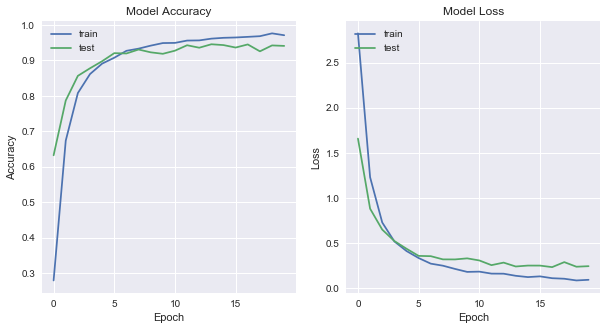

In [9]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['acc']), plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss']), plt.plot(history1.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [10]:
model2 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history2 = model2.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 91s 11ms/step - loss: 2.5959 - acc: 0.3407 - val_loss: 1.4449 - val_acc: 0.6273
Epoch 2/20
8514/8514 [==============================] - 92s 11ms/step - loss: 1.0421 - acc: 0.7228 - val_loss: 0.7857 - val_acc: 0.8067
Epoch 3/20
8514/8514 [==============================] - 92s 11ms/step - loss: 0.6244 - acc: 0.8329 - val_loss: 0.5955 - val_acc: 0.8577
Epoch 4/20
8514/8514 [==============================] - 89s 11ms/step - loss: 0.4381 - acc: 0.8829 - val_loss: 0.4520 - val_acc: 0.8962
Epoch 5/20
8514/8514 [==============================] - 90s 11ms/step - loss: 0.3519 - acc: 0.9039 - val_loss: 0.4256 - val_acc: 0.8860
Epoch 6/20
8514/8514 [==============================] - 90s 11ms/step - loss: 0.2836 - acc: 0.9245 - val_loss: 0.3751 - val_acc: 0.9031
Epoch 7/20
8514/8514 [==============================] - 91s 11ms/step - loss: 0.2426 - acc: 0.9318 - val_loss: 0.3317 - val_acc: 0.9189


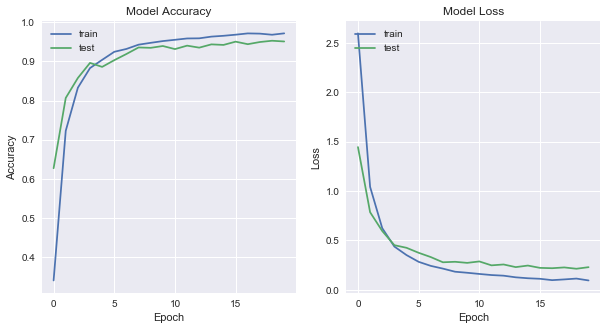

In [11]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['acc']), plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss']), plt.plot(history2.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Dropout)

In [12]:
model3 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history3 = model3.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 74s 9ms/step - loss: 2.1380 - acc: 0.4489 - val_loss: 0.8593 - val_acc: 0.7696
Epoch 2/20
8514/8514 [==============================] - 72s 9ms/step - loss: 0.6423 - acc: 0.8235 - val_loss: 0.4292 - val_acc: 0.8975
Epoch 3/20
8514/8514 [==============================] - 72s 8ms/step - loss: 0.3556 - acc: 0.9003 - val_loss: 0.2989 - val_acc: 0.9240
Epoch 4/20
8514/8514 [==============================] - 73s 9ms/step - loss: 0.2600 - acc: 0.9252 - val_loss: 0.2304 - val_acc: 0.9420
Epoch 5/20
8514/8514 [==============================] - 72s 9ms/step - loss: 0.1827 - acc: 0.9475 - val_loss: 0.2230 - val_acc: 0.9430
Epoch 6/20
8514/8514 [==============================] - 72s 8ms/step - loss: 0.1539 - acc: 0.9528 - val_loss: 0.1831 - val_acc: 0.9522
Epoch 7/20
8514/8514 [==============================] - 75s 9ms/step - loss: 0.1342 - acc: 0.9615 - val_loss: 0.2206 - val_acc: 0.9411
Epoch 8

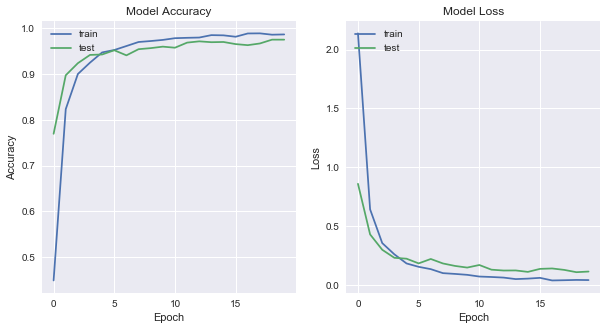

In [13]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['acc']), plt.plot(history3.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss']), plt.plot(history3.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [14]:
model4 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history4 = model4.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 107s 13ms/step - loss: 2.1470 - acc: 0.4400 - val_loss: 0.8119 - val_acc: 0.7974
Epoch 2/20
8514/8514 [==============================] - 95s 11ms/step - loss: 0.6403 - acc: 0.8183 - val_loss: 0.4798 - val_acc: 0.8679
Epoch 3/20
8514/8514 [==============================] - 100s 12ms/step - loss: 0.3817 - acc: 0.8897 - val_loss: 0.2774 - val_acc: 0.9365
Epoch 4/20
8514/8514 [==============================] - 102s 12ms/step - loss: 0.2600 - acc: 0.9252 - val_loss: 0.2293 - val_acc: 0.9425
Epoch 5/20
8514/8514 [==============================] - 95s 11ms/step - loss: 0.1841 - acc: 0.9463 - val_loss: 0.2210 - val_acc: 0.9430
Epoch 6/20
8514/8514 [==============================] - 101s 12ms/step - loss: 0.1764 - acc: 0.9464 - val_loss: 0.1967 - val_acc: 0.9495
Epoch 7/20
8514/8514 [==============================] - 107s 13ms/step - loss: 0.1285 - acc: 0.9610 - val_loss: 0.1722 - val_acc: 0.

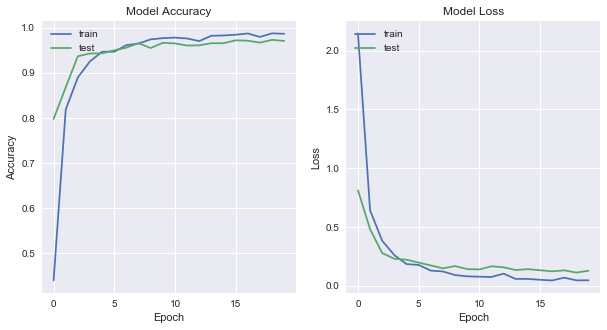

In [15]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['acc']), plt.plot(history4.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss']), plt.plot(history4.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [16]:
model5 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history5 = model5.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 157s 18ms/step - loss: 2.0457 - acc: 0.4654 - val_loss: 0.7613 - val_acc: 0.7969
Epoch 2/20
8514/8514 [==============================] - 154s 18ms/step - loss: 0.5760 - acc: 0.8356 - val_loss: 0.3475 - val_acc: 0.9147
Epoch 3/20
8514/8514 [==============================] - 154s 18ms/step - loss: 0.3245 - acc: 0.9066 - val_loss: 0.2615 - val_acc: 0.9425
Epoch 4/20
8514/8514 [==============================] - 154s 18ms/step - loss: 0.2405 - acc: 0.9294 - val_loss: 0.2028 - val_acc: 0.9467
Epoch 5/20
8514/8514 [==============================] - 157s 18ms/step - loss: 0.1718 - acc: 0.9508 - val_loss: 0.1850 - val_acc: 0.9555
Epoch 6/20
8514/8514 [==============================] - 155s 18ms/step - loss: 0.1409 - acc: 0.9581 - val_loss: 0.1559 - val_acc: 0.9592
Epoch 7/20
8514/8514 [==============================] - 155s 18ms/step - loss: 0.1186 - acc: 0.9635 - val_loss: 0.1538 - val_acc: 

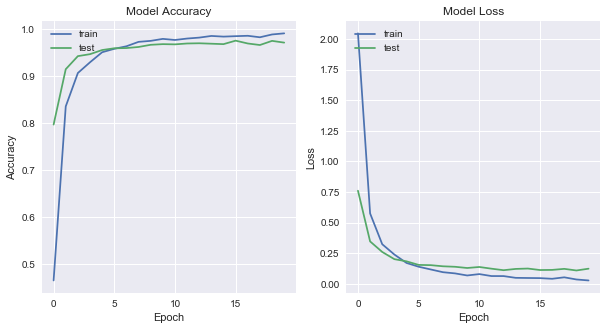

In [17]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['acc']), plt.plot(history5.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss']), plt.plot(history5.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Pool-Conv-Pool-Dropout)

Since model6 and model7 demonstrated minimal signs of overfitting after epochs = 20 initially, deeper epochs (epochs = 40) are examined.

In [18]:
model6 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Dropout(0.25), keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model6.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history6 = model6.fit(und_train, y_class_bin, epochs = 40, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/40
8514/8514 [==============================] - 28s 3ms/step - loss: 2.7675 - acc: 0.2737 - val_loss: 1.5863 - val_acc: 0.5999
Epoch 2/40
8514/8514 [==============================] - 28s 3ms/step - loss: 1.1845 - acc: 0.6519 - val_loss: 0.8680 - val_acc: 0.7603
Epoch 3/40
8514/8514 [==============================] - 22s 3ms/step - loss: 0.7274 - acc: 0.7841 - val_loss: 0.5771 - val_acc: 0.8493
Epoch 4/40
8514/8514 [==============================] - 25s 3ms/step - loss: 0.5435 - acc: 0.8405 - val_loss: 0.4437 - val_acc: 0.8841
Epoch 5/40
8514/8514 [==============================] - 28s 3ms/step - loss: 0.4140 - acc: 0.8789 - val_loss: 0.3396 - val_acc: 0.9119
Epoch 6/40
8514/8514 [==============================] - 23s 3ms/step - loss: 0.3300 - acc: 0.9020 - val_loss: 0.3291 - val_acc: 0.9128
Epoch 7/40
8514/8514 [==============================] - 24s 3ms/step - loss: 0.2800 - acc: 0.9192 - val_loss: 0.2780 - val_acc: 0.9226
Epoch 8

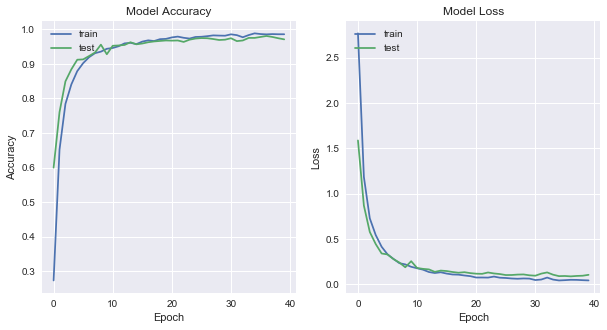

In [19]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['acc']), plt.plot(history6.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss']), plt.plot(history6.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [20]:
model7 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model7.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history7 = model7.fit(und_train, y_class_bin, epochs = 40, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/40
8514/8514 [==============================] - 50s 6ms/step - loss: 2.7823 - acc: 0.2697 - val_loss: 1.5145 - val_acc: 0.5902
Epoch 2/40
8514/8514 [==============================] - 47s 5ms/step - loss: 1.1891 - acc: 0.6510 - val_loss: 0.8668 - val_acc: 0.7752
Epoch 3/40
8514/8514 [==============================] - 46s 5ms/step - loss: 0.7393 - acc: 0.7795 - val_loss: 0.5737 - val_acc: 0.8470
Epoch 4/40
8514/8514 [==============================] - 52s 6ms/step - loss: 0.5405 - acc: 0.8384 - val_loss: 0.4419 - val_acc: 0.8716
Epoch 5/40
8514/8514 [==============================] - 44s 5ms/step - loss: 0.4298 - acc: 0.8728 - val_loss: 0.4206 - val_acc: 0.8744
Epoch 6/40
8514/8514 [==============================] - 46s 5ms/step - loss: 0.3243 - acc: 0.9040 - val_loss: 0.2902 - val_acc: 0.9138
Epoch 7/40
8514/8514 [==============================] - 50s 6ms/step - loss: 0.2908 - acc: 0.9116 - val_loss: 0.2917 - val_acc: 0.9152
Epoch 8

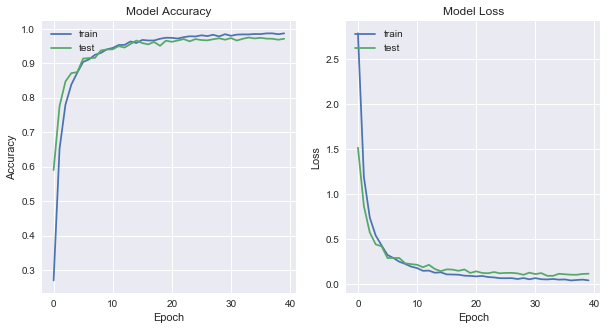

In [21]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['acc']), plt.plot(history7.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss']), plt.plot(history7.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium-Large (Conv-Pool-Conv-Pool-Conv-Pool-Dropout)

Since model8 and model9 demonstrated minimal signs of overfitting after epochs = 40 initially, deeper epochs (epochs = 60) are examined.

In [70]:
model8 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model8.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history8 = model8.fit(und_train, y_class_bin, epochs = 110, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/110
8514/8514 [==============================] - 19s 2ms/step - loss: 3.6928 - acc: 0.0404 - val_loss: 3.5087 - val_acc: 0.0742
Epoch 2/110
8514/8514 [==============================] - 19s 2ms/step - loss: 2.8487 - acc: 0.1971 - val_loss: 2.0847 - val_acc: 0.3922
Epoch 3/110
8514/8514 [==============================] - 22s 3ms/step - loss: 1.9165 - acc: 0.4233 - val_loss: 1.4726 - val_acc: 0.5772
Epoch 4/110
8514/8514 [==============================] - 17s 2ms/step - loss: 1.4877 - acc: 0.5438 - val_loss: 1.0848 - val_acc: 0.6949
Epoch 5/110
8514/8514 [==============================] - 18s 2ms/step - loss: 1.2712 - acc: 0.6001 - val_loss: 0.8969 - val_acc: 0.7534
Epoch 6/110
8514/8514 [==============================] - 22s 3ms/step - loss: 1.1197 - acc: 0.6494 - val_loss: 0.8260 - val_acc: 0.7830
Epoch 7/110
8514/8514 [==============================] - 17s 2ms/step - loss: 0.9813 - acc: 0.6932 - val_loss: 0.7174 - val_acc: 0.8132


8514/8514 [==============================] - 18s 2ms/step - loss: 0.2076 - acc: 0.9373 - val_loss: 0.1904 - val_acc: 0.9546
Epoch 61/110
8514/8514 [==============================] - 16s 2ms/step - loss: 0.2020 - acc: 0.9407 - val_loss: 0.1769 - val_acc: 0.9527
Epoch 62/110
8514/8514 [==============================] - 21s 3ms/step - loss: 0.1927 - acc: 0.9409 - val_loss: 0.1935 - val_acc: 0.9481
Epoch 63/110
8514/8514 [==============================] - 22s 3ms/step - loss: 0.1921 - acc: 0.9427 - val_loss: 0.1701 - val_acc: 0.9522
Epoch 64/110
8514/8514 [==============================] - 16s 2ms/step - loss: 0.2022 - acc: 0.9366 - val_loss: 0.1866 - val_acc: 0.9471
Epoch 65/110
8514/8514 [==============================] - 18s 2ms/step - loss: 0.1981 - acc: 0.9399 - val_loss: 0.1925 - val_acc: 0.9471
Epoch 66/110
8514/8514 [==============================] - 22s 3ms/step - loss: 0.1962 - acc: 0.9419 - val_loss: 0.2034 - val_acc: 0.9453
Epoch 67/110
8514/8514 [==============================

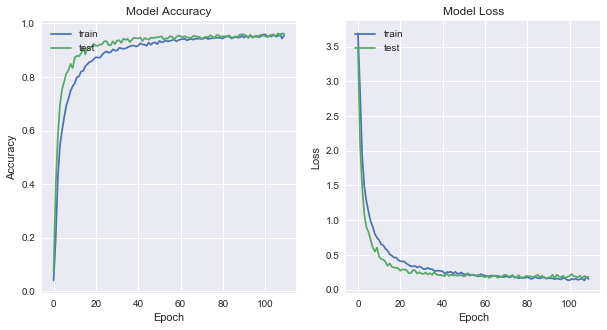

In [71]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history8.history['acc']), plt.plot(history8.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history8.history['loss']), plt.plot(history8.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [50]:
model9 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model9.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history9 = model9.fit(und_train, y_class_bin, epochs = 90, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/90
8514/8514 [==============================] - 22s 3ms/step - loss: 3.6009 - acc: 0.0611 - val_loss: 3.1503 - val_acc: 0.1085
Epoch 2/90
8514/8514 [==============================] - 20s 2ms/step - loss: 2.2265 - acc: 0.3500 - val_loss: 1.6422 - val_acc: 0.5280
Epoch 3/90
8514/8514 [==============================] - 22s 3ms/step - loss: 1.4115 - acc: 0.5641 - val_loss: 1.1048 - val_acc: 0.6694
Epoch 4/90
8514/8514 [==============================] - 21s 2ms/step - loss: 1.0115 - acc: 0.6778 - val_loss: 0.7714 - val_acc: 0.8002
Epoch 5/90
8514/8514 [==============================] - 25s 3ms/step - loss: 0.7978 - acc: 0.7505 - val_loss: 0.6684 - val_acc: 0.8085
Epoch 6/90
8514/8514 [==============================] - 25s 3ms/step - loss: 0.6741 - acc: 0.7878 - val_loss: 0.4671 - val_acc: 0.8618
Epoch 7/90
8514/8514 [==============================] - 27s 3ms/step - loss: 0.5480 - acc: 0.8300 - val_loss: 0.4137 - val_acc: 0.8911
Epoch 8

8514/8514 [==============================] - 22s 3ms/step - loss: 0.0679 - acc: 0.9782 - val_loss: 0.1154 - val_acc: 0.9759
Epoch 61/90
8514/8514 [==============================] - 28s 3ms/step - loss: 0.0641 - acc: 0.9803 - val_loss: 0.1821 - val_acc: 0.9573
Epoch 62/90
8514/8514 [==============================] - 29s 3ms/step - loss: 0.0870 - acc: 0.9745 - val_loss: 0.1429 - val_acc: 0.9648
Epoch 63/90
8514/8514 [==============================] - 25s 3ms/step - loss: 0.0573 - acc: 0.9804 - val_loss: 0.1212 - val_acc: 0.9703
Epoch 64/90
8514/8514 [==============================] - 24s 3ms/step - loss: 0.0601 - acc: 0.9813 - val_loss: 0.1317 - val_acc: 0.9689
Epoch 65/90
8514/8514 [==============================] - 25s 3ms/step - loss: 0.0642 - acc: 0.9786 - val_loss: 0.1206 - val_acc: 0.9708
Epoch 66/90
8514/8514 [==============================] - 20s 2ms/step - loss: 0.0543 - acc: 0.9841 - val_loss: 0.1237 - val_acc: 0.9703
Epoch 67/90
8514/8514 [==============================] - 23s

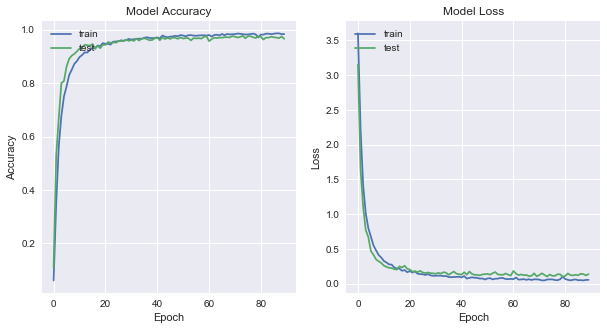

In [51]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history9.history['acc']), plt.plot(history9.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history9.history['loss']), plt.plot(history9.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Final CNN model

The model with the least overfitting behavior and highest performance score is selected (model 7)

CNN classification report: 

               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.94      0.97      0.96       122
           2       0.90      0.93      0.91       124
           3       0.95      0.95      0.95        78
           4       1.00      0.93      0.96       109
           5       0.93      0.92      0.93       102
           6       0.96      1.00      0.98        23
           7       0.99      0.97      0.98        79
           8       0.97      0.97      0.97        78
           9       0.99      1.00      0.99        81
          10       0.98      0.98      0.98       111
          11       1.00      0.96      0.98        73
          12       1.00      0.91      0.95       115
          13       0.98      1.00      0.99       119
          14       0.98      0.98      0.98        43
          15       0.88      1.00      0.93        35
          16       1.00      1.00      1.00        

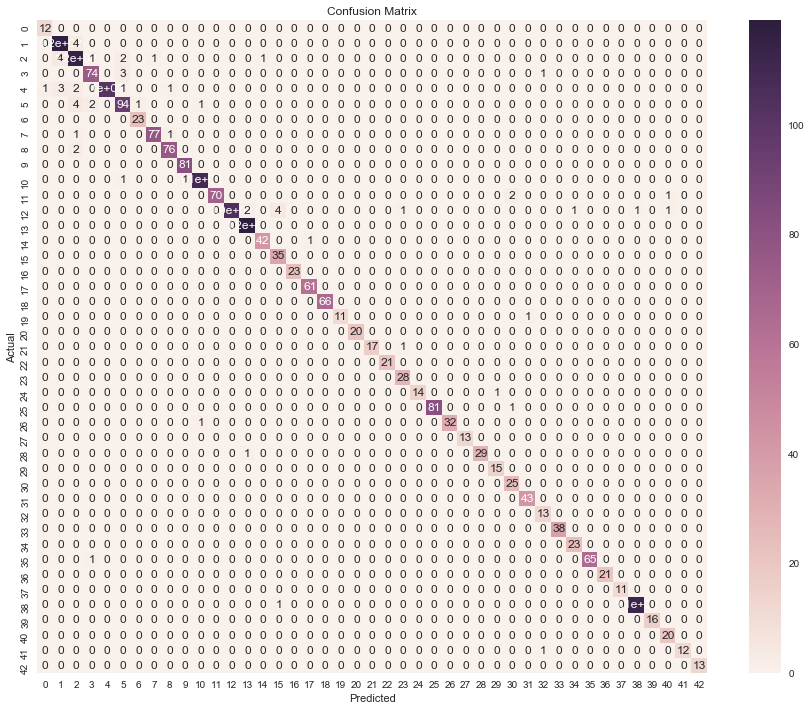

In [81]:
# classification report
y_prob = model7.predict(x_val)
cls_pred = y_prob.argmax(axis = -1)
print("CNN classification report:", "\n\n", classification_report(y_val, cls_pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_val, cls_pred, average = 'weighted')

# accuracy confusion matrix
cm = confusion_matrix(y_val, cls_pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

In [82]:
print('The validation precision score is', precision, '\nThe validation recall score is', recall,\
      '\nThe validation f-score is', fbeta_score)

The validation precision score is 0.972354171367051 
The validation recall score is 0.971256374594344 
The validation f-score is 0.9713405310278461


### Final 3 Models

| Classifiers | Precision | Recall | F-Score |
| --- | --- | --- | --- |
| CNN with the Architecture of Conv-Pool-Conv-Pool-Dropout (model7) | 0.972354 | 0.971256 | 0.971341 |
| Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier from Part II | 0.924908 | 0.918869 | 0.918973 |
| Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier from Part II | 0.923204 | 0.919796 | 0.920249 |
